# Introduction
For this hypothesis test, I used data from Woodworth, O’Brien-Malone, Diamond, and Schüz's article ‘Web-based Positive Psychology Interventions: A Reexamination of Effectiveness’ published in the Journal of Open Psychology Data. From the abstract of that article:

> We present two datasets. The first dataset comprises 992 point-in-time records of self-reported happiness and depression in 295 participants, each assigned to one of four intervention groups, in a study of the effect of web-based positive-psychology interventions. Each point-in-time measurement consists of a participant’s responses to the 24 items of the Authentic Happiness Inventory and to the 20 items of the Center for Epidemiological Studies Depression (CES-D) scale. Measurements were sought at the time of each participant’s enrolment in the study and on five subsequent occasions, the last being approximately 189 days after enrolment. The second dataset contains basic demographic information about each participant.

 My goal in this analysis is to independently verify the conclusions the authors came to, and see if there are any other insights that can be gleaned from the data they gathered.

# 1 Importing

## 1.1 Importing Packages
The data from the study are presented in two CSV tables, which I will import into R dataframes. To create and work with these dataframes, I will import the Tidyverse package, which will provide access to dplyr and ggplot2, among others.

The power analysis will be done with the powerMediation package.

In [1]:
#import tidyverse library, which includes dplyr and ggplot2
library(tidyverse)
library(reshape2)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.1     v dplyr   1.0.0
v tidyr   1.1.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




In [2]:
#import the participant data and experimental data csvs into dataframes
participant_data <- read_csv("participant-info.csv")
experiment_data <- read_csv("ahi-cesd.csv")

Parsed with column specification:
cols(
  id = col_double(),
  intervention = col_double(),
  sex = col_double(),
  age = col_double(),
  educ = col_double(),
  income = col_double()
)

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



# 2 Exploratory Data Analysis
I'll begin the analysis of this study by looking at the data from a few different angles. There are 4 different interventions, and the data were measured over as many as six different instances. 

The dataset shows the respondant values for each question in both the happiness and the depression assessment. I am primarily interested in the aggregate values, so I am going to just keep those.

In [3]:
#remove the data for individual questions from the two surveys, leaving only the total scores
experiment_data_lite <- subset(experiment_data, select = c(id, occasion, elapsed.days, intervention, ahiTotal, cesdTotal))
head(experiment_data_lite)

id,occasion,elapsed.days,intervention,ahiTotal,cesdTotal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.000000,4,63,14
1,1,11.772731,4,73,6
2,0,0.000000,1,73,7
2,1,8.017523,1,89,10
2,2,14.304086,1,89,13
2,3,31.983565,1,93,8


Just at a first glance, I can already see that a major issue was reliable subject partifipaction. While some subjects engaged in 5 follow-up assessemnts, it seems that many never even participated in a single follow-up. To deal with this, I am going to filter out all participants who only did the first visit, since we will have no meaningful follow up data for them.

In [4]:
#group the data by id, and filter out all participants that only took the baseline survey.
exp_data_multionly <- experiment_data_lite %>% 
    group_by(id)%>%
    filter((max(row_number()) > 1))%>%
    ungroup()

The elapsed.days column gives the number of days since the first baseline visit. The value, though, is given to the millionths place, which is useless. I'll round all values in that column to the nearest integer.

In [5]:
#create a column that contains rounded day values for elapsed time and remove the old col
exp_data_multionly <- exp_data_multionly%>%
    mutate(days_since_start = round(elapsed.days, 0))

exp_data_multionly <- subset(exp_data_multionly, select = -c(elapsed.days))

#convert intervention and occasion to factors
exp_data_multionly$intervention <- as.factor(exp_data_multionly$intervention)
exp_data_multionly$occasion <- as.factor(exp_data_multionly$occasion)

I'll get a glimpse at some of the trends by creating a new dataframe called study_summary, which will only contain the mean, median, standard deviation, and count for each intervention-occasion combination. This will allow me to wuickly plot some of the features that may distinguish the different interventions.

In [6]:
study_summary <- exp_data_multionly %>%
    group_by(intervention, occasion)%>%
    summarise(mean_ahi = mean(ahiTotal), 
              med_ahi = median(ahiTotal),
              ahi_sd = sd(ahiTotal),
              mean_cesd = mean(cesdTotal),
              med_cesd = median(cesdTotal),
              cesd_sd = sd(cesdTotal),
              occasion_count = n())

`summarise()` regrouping output by 'intervention' (override with `.groups` argument)



In [7]:
study_summary

intervention,occasion,mean_ahi,med_ahi,ahi_sd,mean_cesd,med_cesd,cesd_sd,occasion_count
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0,67.08889,66.0,13.98834,15.733333,13.0,11.480022,45
1,1,69.53333,70.0,13.41572,15.300000,9.0,14.748816,30
1,2,70.34211,70.5,15.70897,13.578947,10.0,13.865437,38
1,3,75.03448,74.0,12.75730,12.000000,6.0,13.687847,29
1,4,76.50000,78.5,16.16610,11.305556,7.0,10.620249,36
1,5,75.48148,76.0,14.46845,13.518519,7.0,14.129539,27
2,0,69.14035,67.0,12.94830,15.754386,15.0,9.887367,57
2,1,71.58333,73.5,12.51864,14.583333,11.5,11.507321,48
2,2,72.95833,74.0,14.04091,12.166667,9.0,11.785915,48


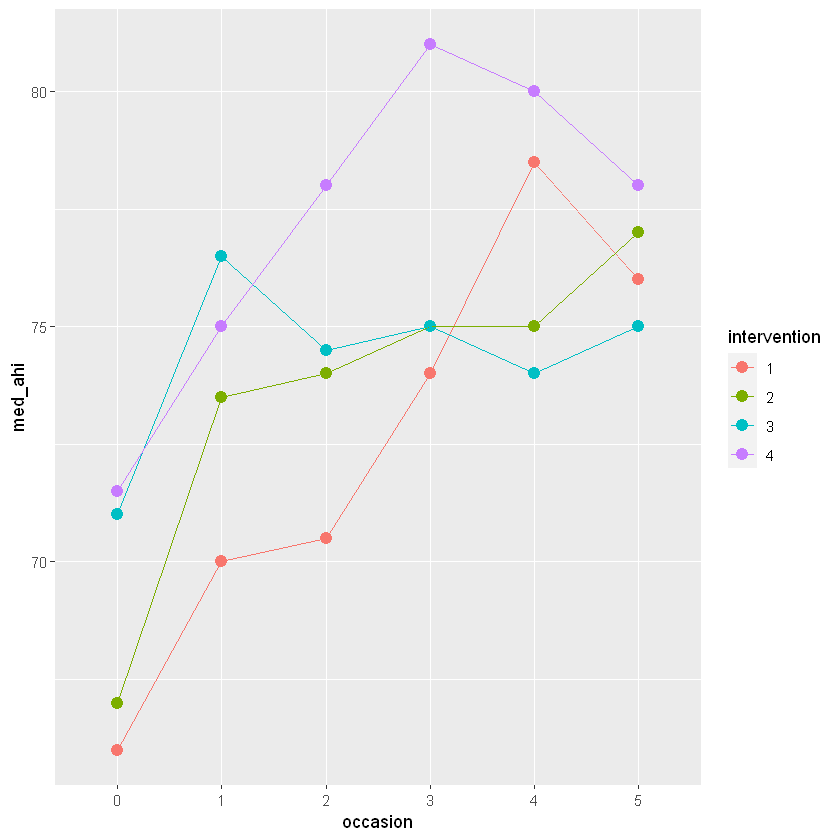

In [8]:
study_summary %>%
    ggplot(., aes(x = occasion, y = med_ahi, color = intervention, group = intervention))+
    geom_point(size = 3)+geom_line()

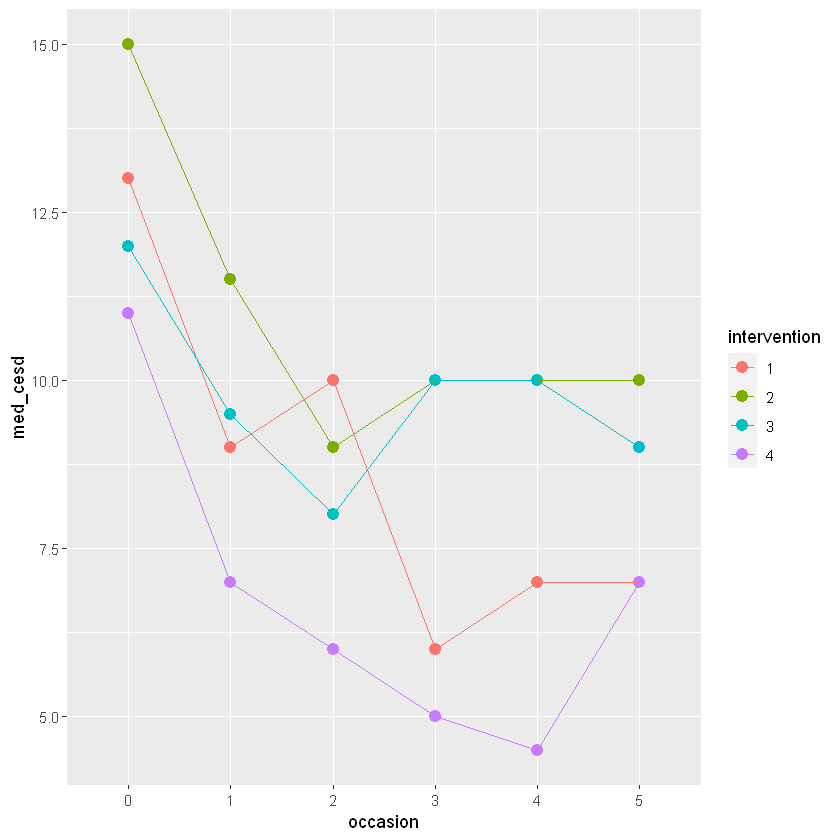

In [9]:
study_summary %>%
    ggplot(., aes(x = occasion, y = med_cesd, color = intervention, group = intervention))+
    geom_point(size = 3)+geom_line()

Now that I have an idea of how the trends are shaped, I want to create a facet grid of the box plots for the complete dataset. I'll facet by intervention, and each box plot will represent one of the occasions.

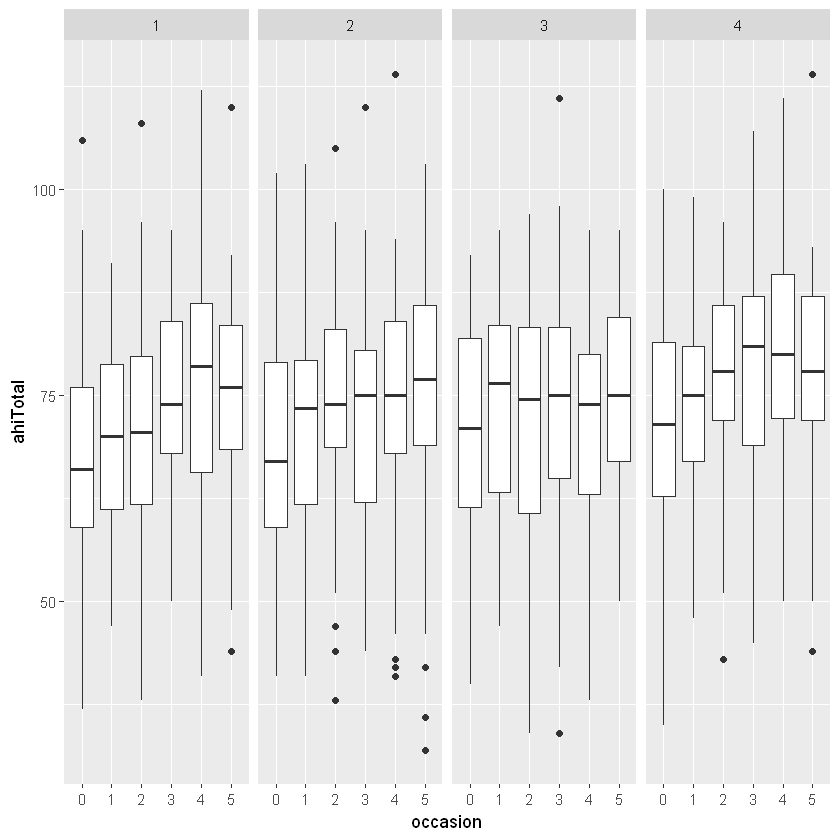

In [10]:
ggplot(exp_data_multionly, aes(x = occasion, y = ahiTotal))+
    geom_boxplot()+
    facet_grid(. ~ intervention)

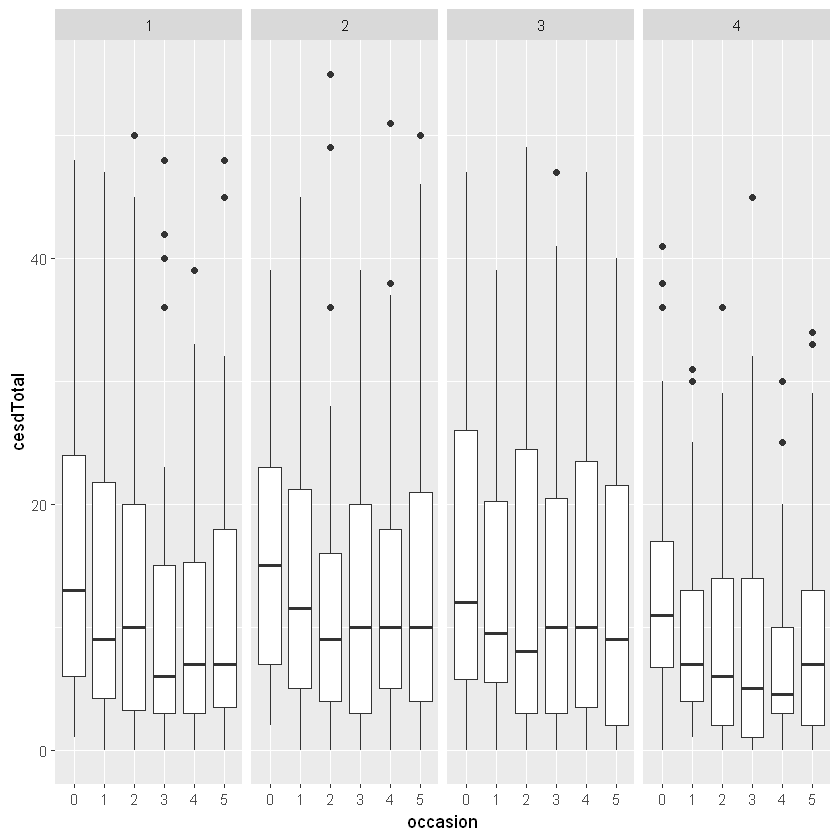

In [11]:
ggplot(exp_data_multionly, aes(x = occasion, y = cesdTotal))+
    geom_boxplot()+
    facet_grid(. ~ intervention)

# 3 Significance Testing
Next I will assess to what degree the variation between the interventions can be explained by random variance versus being explained by a meaningful difference in effect. To do this, I will use ANOVA. The CESD data appear to be skewed, but still realtively normal. The AHI data appear to be highly normal.

For the AHI evaulation, I will look at the 1- and 2- week changes (corresponding to observations 1 and 2, respectively) for each intervention. I will use R's built-in ANOVA function (called aov) to perform this analysis.

## 3.1 ANOVA
I'll use ANOVA to determine if the changes in AHI and CESD were due to expected variance from sampling, or are more likely due to meaningful differences between the efficacies of the different interventions

### 3.1.1 ANOVA on Changes in AHI Score
I'll begin by looking at how the AHI scores changed for the four different interventions, at each of the 5 different occasions of measurement.

In [12]:
#usntack the tall dataframe into a wide dataframe
#create columns for difference calculations
exp_data_ahi <- subset(exp_data_multionly, select = c(id, occasion, intervention, ahiTotal))
cols = c('id', 'ob0', 'ob1', 'ob2', 'ob3', 'ob4', 'ob5')

exp_data_ahi_1 <- exp_data_ahi %>% filter(intervention == 1)
exp_data_ahi_1$intervention <- NULL
exp_data_ahi_1 <- dcast(exp_data_ahi_1, id~occasion, fill = NULL, fun.aggregate = mean, , drop = FALSE)
colnames(exp_data_ahi_1) = cols
exp_data_ahi_1 <- exp_data_ahi_1 %>% mutate(d1wk = ob1-ob0, 
                                            d2wk = ob2-ob0, 
                                            d1mo = ob3-ob0,
                                            d3mo = ob4-ob0,
                                            d6mo = ob5-ob0,
                                            intervention = 1)

exp_data_ahi_2 <- exp_data_ahi %>% filter(intervention == 2)
exp_data_ahi_2$intervention <- NULL
exp_data_ahi_2 <- dcast(exp_data_ahi_2, id~occasion, fill = NULL, fun.aggregate = mean, , drop = FALSE)
colnames(exp_data_ahi_2) = cols
exp_data_ahi_2 <- exp_data_ahi_2 %>% mutate(d1wk = ob1-ob0, 
                                            d2wk = ob2-ob0, 
                                            d1mo = ob3-ob0,
                                            d3mo = ob4-ob0,
                                            d6mo = ob5-ob0,
                                            intervention = 2)

exp_data_ahi_3 <- exp_data_ahi %>% filter(intervention == 3)
exp_data_ahi_3$intervention <- NULL
exp_data_ahi_3 <- dcast(exp_data_ahi_3, id~occasion, fill = NULL, fun.aggregate = mean, , drop = FALSE)
colnames(exp_data_ahi_3) = cols
exp_data_ahi_3 <- exp_data_ahi_3 %>% mutate(d1wk = ob1-ob0, 
                                            d2wk = ob2-ob0, 
                                            d1mo = ob3-ob0,
                                            d3mo = ob4-ob0,
                                            d6mo = ob5-ob0,
                                            intervention = 3)

exp_data_ahi_4 <- exp_data_ahi %>% filter(intervention == 4)
exp_data_ahi_4$intervention <- NULL
exp_data_ahi_4 <- dcast(exp_data_ahi_4, id~occasion, fill = NULL, fun.aggregate = mean, , drop = FALSE)
colnames(exp_data_ahi_4) = cols
exp_data_ahi_4 <- exp_data_ahi_4 %>% mutate(d1wk = ob1-ob0, 
                                            d2wk = ob2-ob0, 
                                            d1mo = ob3-ob0,
                                            d3mo = ob4-ob0,
                                            d6mo = ob5-ob0,
                                            intervention = 4)

#row-bind the four dfs into a single df
exp_data_ahi_diffs <- rbind(exp_data_ahi_1, exp_data_ahi_2, exp_data_ahi_3, exp_data_ahi_4)
exp_data_ahi_diffs

Using ahiTotal as value column: use value.var to override.

Using ahiTotal as value column: use value.var to override.

Using ahiTotal as value column: use value.var to override.

Using ahiTotal as value column: use value.var to override.



id,ob0,ob1,ob2,ob3,ob4,ob5,d1wk,d2wk,d1mo,d3mo,d6mo,intervention
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,73,89,89,93,80,77,16,16,20,7,4,1
6,62,NaN,67,66,NaN,NaN,NaN,5,4,NaN,NaN,1
19,73,67,NaN,71,66,76,-6,NaN,-2,-7,3,1
28,63,89,87,92,87,92,26,24,29,24,29,1
31,56,64,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,1
34,73,NaN,85,63,72,74,NaN,12,-10,-1,1,1
36,57,58,58,NaN,NaN,NaN,1,1,NaN,NaN,NaN,1
53,76,74,76,NaN,75,81,-2,0,NaN,-1,5,1
64,61,61,66,NaN,63,67,0,5,NaN,2,6,1


Now that the data are melted and in the appropriate format, I'll perform ANOVA to see if the difference between the four interventions is statitstically significant, or if it is more likely just due to random variance inherent to sampling.

In [13]:
#perform anova for each differnce calculation and store the results
ahi_1wk_anova <- aov(d1wk ~ intervention, data = exp_data_ahi_diffs)
ahi_2wk_anova <- aov(d2wk ~ intervention, data = exp_data_ahi_diffs)
ahi_1mo_anova <- aov(d1mo ~ intervention, data = exp_data_ahi_diffs)
ahi_3mo_anova <- aov(d3mo ~ intervention, data = exp_data_ahi_diffs)
ahi_6mo_anova <- aov(d6mo ~ intervention, data = exp_data_ahi_diffs)

In [14]:
summary(ahi_1wk_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1     10   10.21   0.174  0.677
Residuals    145   8513   58.71               
55 observations deleted due to missingness

In [15]:
summary(ahi_2wk_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1      3    2.82   0.046  0.831
Residuals    154   9535   61.92               
46 observations deleted due to missingness

In [16]:
summary(ahi_1mo_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1     89   88.86   0.764  0.384
Residuals    137  15934  116.31               
63 observations deleted due to missingness

In [17]:
summary(ahi_3mo_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1    161   160.6   1.304  0.256
Residuals    131  16129   123.1               
69 observations deleted due to missingness

In [18]:
summary(ahi_6mo_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1     20   19.78   0.157  0.692
Residuals    118  14838  125.74               
82 observations deleted due to missingness

None of the interventions appear to be particularly distinct from one another in terms of how they impacted participants' happiness index scores. This appears to be the case for all measurement windows (1 week, 2 weeks, 1 month, 3 months, and 6 months). This, of course, does not mean that the interventions were not efficacious, but rather that they are not distinct enough from one another in terms of impact that the differences can be rules to be due to the differing interventions.

The next test will also be an ANOVA test, to determine whether the different interventions had a meaningfully distinct impacts on changes in feelings of depression in participants. 

### 3.1.1 ANOVA on Changes in CESD Score
Next, I'll look at how the CESD scores changed for the four different interventions, at each of the 5 different occasions of measurement.

In [19]:
#usntack the tall dataframe into a wide dataframe
#create columns for difference calculations
exp_data_cesd <- subset(exp_data_multionly, select = c(id, occasion, intervention, cesdTotal))
cols = c('id', 'ob0', 'ob1', 'ob2', 'ob3', 'ob4', 'ob5')

exp_data_cesd_1 <- exp_data_cesd %>% filter(intervention == 1)
exp_data_cesd_1$intervention <- NULL
exp_data_cesd_1 <- dcast(exp_data_cesd_1, id~occasion, fill = NULL, fun.aggregate = mean, , drop = FALSE)
colnames(exp_data_cesd_1) = cols
exp_data_cesd_1 <- exp_data_cesd_1 %>% mutate(d1wk = ob1-ob0, 
                                            d2wk = ob2-ob0, 
                                            d1mo = ob3-ob0,
                                            d3mo = ob4-ob0,
                                            d6mo = ob5-ob0,
                                            intervention = 1)

exp_data_cesd_2 <- exp_data_cesd %>% filter(intervention == 2)
exp_data_cesd_2$intervention <- NULL
exp_data_cesd_2 <- dcast(exp_data_cesd_2, id~occasion, fill = NULL, fun.aggregate = mean, , drop = FALSE)
colnames(exp_data_cesd_2) = cols
exp_data_cesd_2 <- exp_data_cesd_2 %>% mutate(d1wk = ob1-ob0, 
                                            d2wk = ob2-ob0, 
                                            d1mo = ob3-ob0,
                                            d3mo = ob4-ob0,
                                            d6mo = ob5-ob0,
                                            intervention = 2)

exp_data_cesd_3 <- exp_data_cesd %>% filter(intervention == 3)
exp_data_cesd_3$intervention <- NULL
exp_data_cesd_3 <- dcast(exp_data_cesd_3, id~occasion, fill = NULL, fun.aggregate = mean, , drop = FALSE)
colnames(exp_data_cesd_3) = cols
exp_data_cesd_3 <- exp_data_cesd_3 %>% mutate(d1wk = ob1-ob0, 
                                            d2wk = ob2-ob0, 
                                            d1mo = ob3-ob0,
                                            d3mo = ob4-ob0,
                                            d6mo = ob5-ob0,
                                            intervention = 3)

exp_data_cesd_4 <- exp_data_cesd %>% filter(intervention == 4)
exp_data_cesd_4$intervention <- NULL
exp_data_cesd_4 <- dcast(exp_data_cesd_4, id~occasion, fill = NULL, fun.aggregate = mean, , drop = FALSE)
colnames(exp_data_cesd_4) = cols
exp_data_cesd_4 <- exp_data_cesd_4 %>% mutate(d1wk = ob1-ob0, 
                                            d2wk = ob2-ob0, 
                                            d1mo = ob3-ob0,
                                            d3mo = ob4-ob0,
                                            d6mo = ob5-ob0,
                                            intervention = 4)

#row-bind the four dfs into a single df
exp_data_cesd_diffs <- rbind(exp_data_cesd_1, exp_data_cesd_2, exp_data_cesd_3, exp_data_cesd_4)
exp_data_cesd_diffs

Using cesdTotal as value column: use value.var to override.

Using cesdTotal as value column: use value.var to override.

Using cesdTotal as value column: use value.var to override.

Using cesdTotal as value column: use value.var to override.



id,ob0,ob1,ob2,ob3,ob4,ob5,d1wk,d2wk,d1mo,d3mo,d6mo,intervention
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,7,10,13,8,15.0,12,3,6,1,8.0,5,1
6,25,NaN,34,23,NaN,NaN,NaN,9,-2,NaN,NaN,1
19,13,16,NaN,15,15.0,7,3,NaN,2,2.0,-6,1
28,13,2,0,0,2.0,0,-11,-13,-13,-11.0,-13,1
31,12,13,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1
34,17,NaN,12,36,21.0,17,NaN,-5,19,4.0,0,1
36,17,10,11,NaN,NaN,NaN,-7,-6,NaN,NaN,NaN,1
53,5,5,10,NaN,10.0,7,0,5,NaN,5.0,2,1
64,27,22,20,NaN,17.5,19,-5,-7,NaN,-9.5,-8,1


Just as with the AHI measure, I will perform ANOVA on the changes in CESD.

In [20]:
#perform anova for each differnce calculation and store the results
cesd_1wk_anova <- aov(d1wk ~ intervention, data = exp_data_cesd_diffs)
cesd_2wk_anova <- aov(d2wk ~ intervention, data = exp_data_cesd_diffs)
cesd_1mo_anova <- aov(d1mo ~ intervention, data = exp_data_cesd_diffs)
cesd_3mo_anova <- aov(d3mo ~ intervention, data = exp_data_cesd_diffs)
cesd_6mo_anova <- aov(d6mo ~ intervention, data = exp_data_cesd_diffs)

In [21]:
summary(cesd_1wk_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1    136  135.68   2.096   0.15
Residuals    145   9387   64.74               
55 observations deleted due to missingness

In [22]:
summary(cesd_2wk_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1     12   12.03   0.223  0.637
Residuals    154   8290   53.83               
46 observations deleted due to missingness

In [23]:
summary(cesd_1mo_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1      2    1.80   0.023   0.88
Residuals    137  10860   79.27               
63 observations deleted due to missingness

In [24]:
summary(cesd_3mo_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1      0    0.36   0.004  0.951
Residuals    131  12625   96.37               
69 observations deleted due to missingness

In [25]:
summary(cesd_6mo_anova)

              Df Sum Sq Mean Sq F value Pr(>F)
intervention   1     64   63.52   0.605  0.438
Residuals    118  12390  105.00               
82 observations deleted due to missingness

Again, as expected due to the ANOVA results from AHI, there does not seem to be a meaningful difference between the 4 interventions in terms of how uch impact the intervention had on CESD scores.

## 3.2 Significance of Treatment Efficacy
To determine whether the interventions were effective, I will use paired T-tests on each intervention for each time period.

### 3.2.1 Effect of Interventions on AHI Score - Paired T-Test
First, I will look at how each treatment impacted AHI score for each of the given time intervals.

In [26]:
#T test for intervention 1
t.test(exp_data_ahi_1$ob0, exp_data_ahi_1$ob1, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_ahi_2$ob0, exp_data_ahi_2$ob1, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_ahi_3$ob0, exp_data_ahi_3$ob1, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_ahi_4$ob0, exp_data_ahi_4$ob1, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_ahi_1$ob0 and exp_data_ahi_1$ob1
t = -0.7599, df = 64.084, p-value = 0.225
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 2.924305
sample estimates:
mean of x mean of y 
 67.08889  69.53333 



	Welch Two Sample t-test

data:  exp_data_ahi_2$ob0 and exp_data_ahi_2$ob1
t = -0.98063, df = 101.02, p-value = 0.1646
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 1.692678
sample estimates:
mean of x mean of y 
 69.14035  71.58333 



	Welch Two Sample t-test

data:  exp_data_ahi_3$ob0 and exp_data_ahi_3$ob1
t = -1.0553, df = 47.462, p-value = 0.1483
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
    -Inf 2.17086
sample estimates:
mean of x mean of y 
 70.31818  74.00000 



	Welch Two Sample t-test

data:  exp_data_ahi_4$ob0 and exp_data_ahi_4$ob1
t = -0.98049, df = 98.73, p-value = 0.1646
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 1.683614
sample estimates:
mean of x mean of y 
 71.75000  74.17778 


After 1 week, the interventions' impact seems difficult to distinguish from random variation. Next, I'll do another paired t-test to see if the impact is easier to see after 2 weeks.

In [27]:
#T test for intervention 1
t.test(exp_data_ahi_1$ob0, exp_data_ahi_1$ob2, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_ahi_2$ob0, exp_data_ahi_2$ob2, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_ahi_3$ob0, exp_data_ahi_3$ob2, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_ahi_4$ob0, exp_data_ahi_4$ob2, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_ahi_1$ob0 and exp_data_ahi_1$ob2
t = -0.98799, df = 74.9, p-value = 0.1632
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 2.230729
sample estimates:
mean of x mean of y 
 67.08889  70.34211 



	Welch Two Sample t-test

data:  exp_data_ahi_2$ob0 and exp_data_ahi_2$ob2
t = -1.733, df = 97.05, p-value = 0.04314
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf -0.1876521
sample estimates:
mean of x mean of y 
 69.14035  73.63830 



	Welch Two Sample t-test

data:  exp_data_ahi_3$ob0 and exp_data_ahi_3$ob2
t = -0.51761, df = 59.873, p-value = 0.3033
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 4.094677
sample estimates:
mean of x mean of y 
 70.31818  72.15625 



	Welch Two Sample t-test

data:  exp_data_ahi_4$ob0 and exp_data_ahi_4$ob2
t = -1.8058, df = 87.381, p-value = 0.0372
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf -0.3779719
sample estimates:
mean of x mean of y 
 71.75000  76.51282 


Now two of the interventions have a mean greater than the pre-intervention value, with a p-value less than 0.05. Next, I'll compare the values for 1 month.

In [28]:
#T test for intervention 1
t.test(exp_data_ahi_1$ob0, exp_data_ahi_1$ob3, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_ahi_2$ob0, exp_data_ahi_2$ob3, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_ahi_3$ob0, exp_data_ahi_3$ob3, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_ahi_4$ob0, exp_data_ahi_4$ob3, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_ahi_1$ob0 and exp_data_ahi_1$ob3
t = -2.5176, df = 63.818, p-value = 0.007168
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf -2.67797
sample estimates:
mean of x mean of y 
 67.08889  75.03448 



	Welch Two Sample t-test

data:  exp_data_ahi_2$ob0 and exp_data_ahi_2$ob3
t = -1.2038, df = 85.887, p-value = 0.116
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 1.267774
sample estimates:
mean of x mean of y 
 69.14035  72.46512 



	Welch Two Sample t-test

data:  exp_data_ahi_3$ob0 and exp_data_ahi_3$ob3
t = -0.97026, df = 54.177, p-value = 0.1681
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 2.595959
sample estimates:
mean of x mean of y 
 70.31818  73.90000 



	Welch Two Sample t-test

data:  exp_data_ahi_4$ob0 and exp_data_ahi_4$ob3
t = -1.7125, df = 69.009, p-value = 0.04565
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf -0.1424011
sample estimates:
mean of x mean of y 
 71.75000  77.13514 


As with obserbvation 2, treatment 4 seems to have a statistically significant effect. Treatmet 2 did not show a meaningful effect this time, but treatment 1 showed a very straong effect. Now I'll see how strong an effect there was after 3 months.

In [29]:
#T test for intervention 1
t.test(exp_data_ahi_1$ob0, exp_data_ahi_1$ob4, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_ahi_2$ob0, exp_data_ahi_2$ob4, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_ahi_3$ob0, exp_data_ahi_3$ob4, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_ahi_4$ob0, exp_data_ahi_4$ob4, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_ahi_1$ob0 and exp_data_ahi_1$ob4
t = -2.8435, df = 67.293, p-value = 0.002952
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf -4.05058
sample estimates:
mean of x mean of y 
 67.08889  76.88571 



	Welch Two Sample t-test

data:  exp_data_ahi_2$ob0 and exp_data_ahi_2$ob4
t = -1.3288, df = 63.523, p-value = 0.09433
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 1.099498
sample estimates:
mean of x mean of y 
 69.14035  73.43243 



	Welch Two Sample t-test

data:  exp_data_ahi_3$ob0 and exp_data_ahi_3$ob4
t = -0.21662, df = 52.688, p-value = 0.4147
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 5.086606
sample estimates:
mean of x mean of y 
 70.31818  71.07407 



	Welch Two Sample t-test

data:  exp_data_ahi_4$ob0 and exp_data_ahi_4$ob4
t = -2.4318, df = 68.334, p-value = 0.008826
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -2.278669
sample estimates:
mean of x mean of y 
    71.75     79.00 


As with observation 3, treatments 1 and 4 showed a significant effect, while the others did not. Last one to check is observation 5.

In [30]:
#T test for intervention 1
t.test(exp_data_ahi_1$ob0, exp_data_ahi_1$ob5, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_ahi_2$ob0, exp_data_ahi_2$ob5, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_ahi_3$ob0, exp_data_ahi_3$ob5, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_ahi_4$ob0, exp_data_ahi_4$ob5, alternative = "less", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_ahi_1$ob0 and exp_data_ahi_1$ob5
t = -2.4126, df = 53.414, p-value = 0.009653
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -2.569613
sample estimates:
mean of x mean of y 
 67.08889  75.48148 



	Welch Two Sample t-test

data:  exp_data_ahi_2$ob0 and exp_data_ahi_2$ob5
t = -1.6906, df = 65.001, p-value = 0.04785
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
        -Inf -0.06961288
sample estimates:
mean of x mean of y 
 69.14035  74.48649 



	Welch Two Sample t-test

data:  exp_data_ahi_3$ob0 and exp_data_ahi_3$ob5
t = -1.2017, df = 44.878, p-value = 0.1179
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 1.688682
sample estimates:
mean of x mean of y 
 70.31818  74.56522 



	Welch Two Sample t-test

data:  exp_data_ahi_4$ob0 and exp_data_ahi_4$ob5
t = -2.2872, df = 67.28, p-value = 0.01267
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
      -Inf -1.831948
sample estimates:
mean of x mean of y 
 71.75000  78.51515 


Treatments 1, 2, and 4 all showed statistically significant differences from the original value.


### 3.2.2 Effect of Interventions on CESD Score - Paired T-Test
Next, I will see what effect the four treatments had on the depression (CESD) index.

In [31]:
#T test for intervention 1
t.test(exp_data_cesd_1$ob0, exp_data_cesd_1$ob1, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_cesd_2$ob0, exp_data_cesd_2$ob1, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_cesd_3$ob0, exp_data_cesd_3$ob1, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_cesd_4$ob0, exp_data_cesd_4$ob1, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_cesd_1$ob0 and exp_data_cesd_1$ob1
t = 0.13582, df = 51.608, p-value = 0.4462
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -4.910581       Inf
sample estimates:
mean of x mean of y 
 15.73333  15.30000 



	Welch Two Sample t-test

data:  exp_data_cesd_2$ob0 and exp_data_cesd_2$ob1
t = 0.55365, df = 93.33, p-value = 0.2906
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -2.342919       Inf
sample estimates:
mean of x mean of y 
 15.75439  14.58333 



	Welch Two Sample t-test

data:  exp_data_cesd_3$ob0 and exp_data_cesd_3$ob1
t = 1.2939, df = 56.309, p-value = 0.1005
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -1.113503       Inf
sample estimates:
mean of x mean of y 
 16.43182  12.62500 



	Welch Two Sample t-test

data:  exp_data_cesd_4$ob0 and exp_data_cesd_4$ob1
t = 1.8573, df = 99, p-value = 0.03312
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.3379442       Inf
sample estimates:
mean of x mean of y 
13.053571  9.866667 


No significant effect is observable on depressive symptoms after just 1 week of intervention for any of the interventions. Next, I'll check afer 2 weeks.

In [32]:
#T test for intervention 1
t.test(exp_data_cesd_1$ob0, exp_data_cesd_1$ob2, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_cesd_2$ob0, exp_data_cesd_2$ob2, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_cesd_3$ob0, exp_data_cesd_3$ob2, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_cesd_4$ob0, exp_data_cesd_4$ob2, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_cesd_1$ob0 and exp_data_cesd_1$ob2
t = 0.76227, df = 71.959, p-value = 0.2242
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -2.555076       Inf
sample estimates:
mean of x mean of y 
 15.73333  13.57895 



	Welch Two Sample t-test

data:  exp_data_cesd_2$ob0 and exp_data_cesd_2$ob2
t = 2.224, df = 96.59, p-value = 0.01424
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 1.123243      Inf
sample estimates:
mean of x mean of y 
 15.75439  11.31915 



	Welch Two Sample t-test

data:  exp_data_cesd_3$ob0 and exp_data_cesd_3$ob2
t = 0.50148, df = 61.872, p-value = 0.3089
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -3.845581       Inf
sample estimates:
mean of x mean of y 
 16.43182  14.78125 



	Welch Two Sample t-test

data:  exp_data_cesd_4$ob0 and exp_data_cesd_4$ob2
t = 1.8755, df = 85.45, p-value = 0.03207
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.4071603       Inf
sample estimates:
mean of x mean of y 
13.053571  9.461538 


Treatment 2 seems to be shwoing a statistically significant impact, but I'll check the subsequent observations to see if that impact was lasting.

In [33]:
#T test for intervention 1
t.test(exp_data_cesd_1$ob0, exp_data_cesd_1$ob3, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_cesd_2$ob0, exp_data_cesd_2$ob3, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_cesd_3$ob0, exp_data_cesd_3$ob3, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_cesd_4$ob0, exp_data_cesd_4$ob3, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_cesd_1$ob0 and exp_data_cesd_1$ob3
t = 1.2184, df = 52.3, p-value = 0.1143
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -1.397703       Inf
sample estimates:
mean of x mean of y 
 15.73333  12.00000 



	Welch Two Sample t-test

data:  exp_data_cesd_2$ob0 and exp_data_cesd_2$ob3
t = 1.5743, df = 87.962, p-value = 0.0595
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -0.1813165        Inf
sample estimates:
mean of x mean of y 
 15.75439  12.51163 



	Welch Two Sample t-test

data:  exp_data_cesd_3$ob0 and exp_data_cesd_3$ob3
t = 0.91501, df = 62.856, p-value = 0.1818
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -2.334934       Inf
sample estimates:
mean of x mean of y 
 16.43182  13.60000 



	Welch Two Sample t-test

data:  exp_data_cesd_4$ob0 and exp_data_cesd_4$ob3
t = 1.7983, df = 70.899, p-value = 0.03819
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.2869599       Inf
sample estimates:
mean of x mean of y 
13.053571  9.135135 


Treatment 4 seems to show a significant impact, and treatment 2 appears to have possibly had some impact. Next, I will check the 3 month mark.

In [34]:
#T test for intervention 1
t.test(exp_data_cesd_1$ob0, exp_data_cesd_1$ob4, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_cesd_2$ob0, exp_data_cesd_2$ob4, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_cesd_3$ob0, exp_data_cesd_3$ob4, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_cesd_4$ob0, exp_data_cesd_4$ob4, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_cesd_1$ob0 and exp_data_cesd_1$ob4
t = 1.848, df = 75.381, p-value = 0.03427
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.4551122       Inf
sample estimates:
mean of x mean of y 
 15.73333  11.12857 



	Welch Two Sample t-test

data:  exp_data_cesd_2$ob0 and exp_data_cesd_2$ob4
t = 0.97121, df = 65.717, p-value = 0.1675
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -1.666783       Inf
sample estimates:
mean of x mean of y 
 15.75439  13.43243 



	Welch Two Sample t-test

data:  exp_data_cesd_3$ob0 and exp_data_cesd_3$ob4
t = 0.44476, df = 50.181, p-value = 0.3292
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -4.270617       Inf
sample estimates:
mean of x mean of y 
 16.43182  14.88889 



	Welch Two Sample t-test

data:  exp_data_cesd_4$ob0 and exp_data_cesd_4$ob4
t = 2.9768, df = 83.433, p-value = 0.001906
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 2.346616      Inf
sample estimates:
mean of x mean of y 
13.053571  7.735294 


In [35]:
#T test for intervention 1
t.test(exp_data_cesd_1$ob0, exp_data_cesd_1$ob5, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 2
t.test(exp_data_cesd_2$ob0, exp_data_cesd_2$ob5, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 3
t.test(exp_data_cesd_3$ob0, exp_data_cesd_3$ob5, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)

#T test for intervention 4
t.test(exp_data_cesd_4$ob0, exp_data_cesd_4$ob5, alternative = "greater", mu=0, paired = FALSE, conf.level = 0.95)



	Welch Two Sample t-test

data:  exp_data_cesd_1$ob0 and exp_data_cesd_1$ob5
t = 0.68934, df = 46.376, p-value = 0.247
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -3.177702       Inf
sample estimates:
mean of x mean of y 
 15.73333  13.51852 



	Welch Two Sample t-test

data:  exp_data_cesd_2$ob0 and exp_data_cesd_2$ob5
t = 0.44587, df = 58.811, p-value = 0.3287
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -3.261554       Inf
sample estimates:
mean of x mean of y 
 15.75439  14.56757 



	Welch Two Sample t-test

data:  exp_data_cesd_3$ob0 and exp_data_cesd_3$ob5
t = 1.0203, df = 45.891, p-value = 0.1565
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -2.186815       Inf
sample estimates:
mean of x mean of y 
 16.43182  13.04348 



	Welch Two Sample t-test

data:  exp_data_cesd_4$ob0 and exp_data_cesd_4$ob5
t = 1.2788, df = 61.755, p-value = 0.1029
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -0.8784161        Inf
sample estimates:
mean of x mean of y 
 13.05357  10.18182 


None of the differences at this point are distinguishable from random noise.

# 4 Conclusions
The four treatments all appear to have had some measurable and significant impact on happiness, there seems to have been little to no meaningful impact on the experience of depressive symptoms as quantified by the CESD. 

None of the 4 treatments are significantly different from one another. The majority of the differnce between the four treatments seems to be explained by the differences between the particiants that were assigned to the four groups.